### Edgar Moises Hernandez-Gonzalez
#### 17/04/20-20/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x4
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6048, 11000)
(6048, 11000)
(6048, 1)
(6048, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 6048
n_samples_test : 6048


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
#le = LabelEncoder().fit(y_train)
#y_train = le.transform(y_train)
#_test = le.transform(y_test)

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (4, 264) #ancho, alto
  fs = 250
  datos = np.zeros((6048,264,4))
  temporal = np.zeros((528,2))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*500:(j+1)*500]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(6048, 264, 4)
(6048, 264, 4)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

67.42340492222856
55.28679494298277
0.00015417410020847705
0.00044794910241258623
1.1814394923763425
1.183555617428332


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 68.0
x_test /= 68.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9915207
0.81304115
2.2672662e-06
6.587487e-06
0.017374111
0.017405225


In [0]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(6048, 264, 4, 1)
(6048, 264, 4, 1)


In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
'''def CNN_2D_BN():
  model = Sequential()
  model.add(Conv2D(8, (3,3), padding='same', input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(64))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

Iteration: 1
loss:  1.4873437399941463
accuracy:  0.5775462985038757
kappa:  0.43672839506172845
confusion matrix:
 [[ 903  318  157  134]
 [ 461  817  199   35]
 [ 146   32  762  572]
 [  97    8  396 1011]]


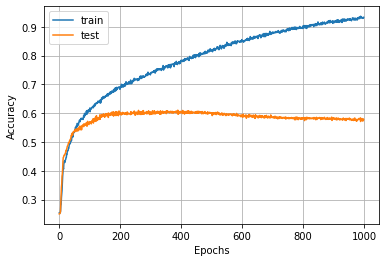

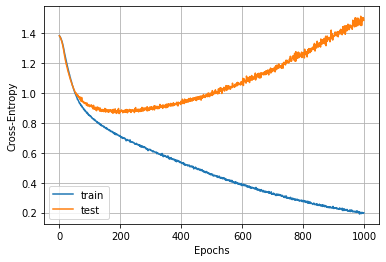

Iteration: 2
loss:  1.5463380496702577
accuracy:  0.5810185074806213
kappa:  0.441358024691358
confusion matrix:
 [[ 854  306  164  188]
 [ 473  780  202   57]
 [  87   28  782  615]
 [  60   12  342 1098]]


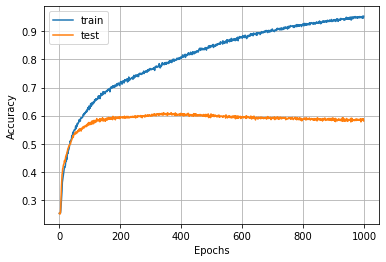

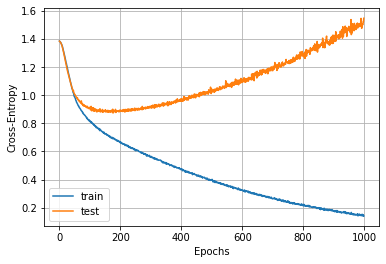

Iteration: 3
loss:  1.4027987273173437
accuracy:  0.5922619104385376
kappa:  0.4563492063492064
confusion matrix:
 [[ 939  283  147  143]
 [ 477  784  196   55]
 [ 112   34  812  554]
 [  70    7  388 1047]]


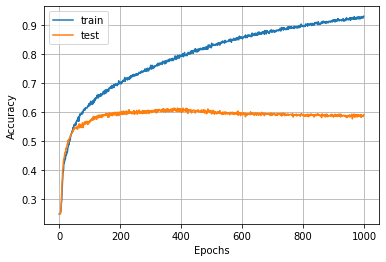

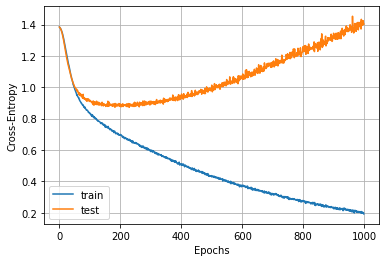

Iteration: 4
loss:  1.503774326422779
accuracy:  0.5790343880653381
kappa:  0.4387125220458554
confusion matrix:
 [[ 808  355  134  215]
 [ 425  824  188   75]
 [  90   27  779  616]
 [  62    6  353 1091]]


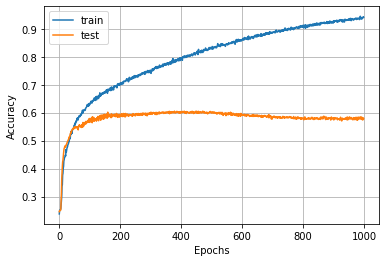

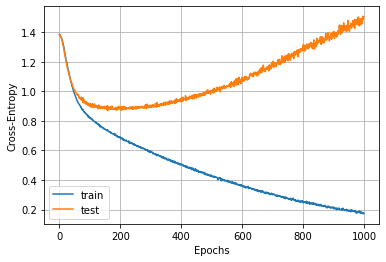

Iteration: 5
loss:  1.4480825420912533
accuracy:  0.5970568656921387
kappa:  0.4627425044091711
confusion matrix:
 [[ 798  345  153  216]
 [ 387  877  190   58]
 [  99   28  837  548]
 [  56   15  342 1099]]


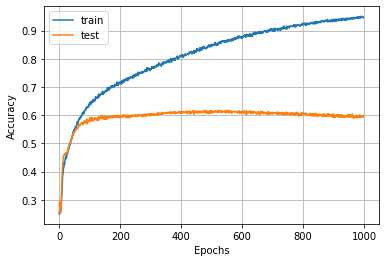

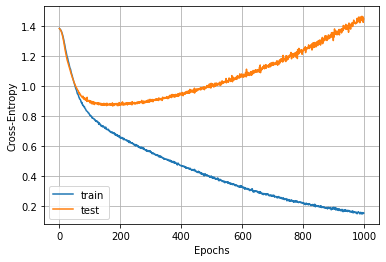


Resultados:
loss: [1.4873437399941463, 1.5463380496702577, 1.4027987273173437, 1.503774326422779, 1.4480825420912533]
accuracy: [0.5775462985038757, 0.5810185074806213, 0.5922619104385376, 0.5790343880653381, 0.5970568656921387]
kappa: [0.43672839506172845, 0.441358024691358, 0.4563492063492064, 0.4387125220458554, 0.4627425044091711]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=1000, batch_size=512,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 264, 4, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 132, 2, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 132, 2, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 66, 1, 16)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                67648     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)               

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.5854
std: (+/- 0.0078)
Mean Kappa: 0.4472
std: (+/- 0.0104)
Max Accuracy: 0.5971
Max Kappa: 0.4627
